# SARIMAX Tutorial

## AutoRegressive Integrated Moving Average (ARIMA)

The standard ARIMA(p,d,q) is a predictive filter for non-seasonal time series data. Each parameter is:

* p: the order of the AR filter Y_t = sum(a_k * Y_(t-k)) + alpha + error   k= 1 to p
* q: the order of the MA filter Y_t = sum(b_k * e_(t-k)) + alpha + error   k= 0 to p
* d: Minimum number of differences to make time series stationary associated with the I component

Note: MA is a linear sum of lagged residuals, as ideally the residual term will be orthogonal to the previous Y_t values and residual terms. This is acheived if the process is Gaussian and the residual is then white noise which is also a Gaussian process with R(0)=q and R(k=/=0)=0.

### Determine d

The adequacy of d can be seen by viewing the autocorrelation plot. If many terms have autocorrelation above the significance level (eg 10), further differences must be taken. Alternativly if the Lag 1 coeffciecnt is a large negative value then d is too big.

Below the ADF test is used. The null hypothesis is that the series is nonstationary, thus a p value less than the significance level (generally p = 0.05) will mean the series is stationary as we reject the null hypothesis 

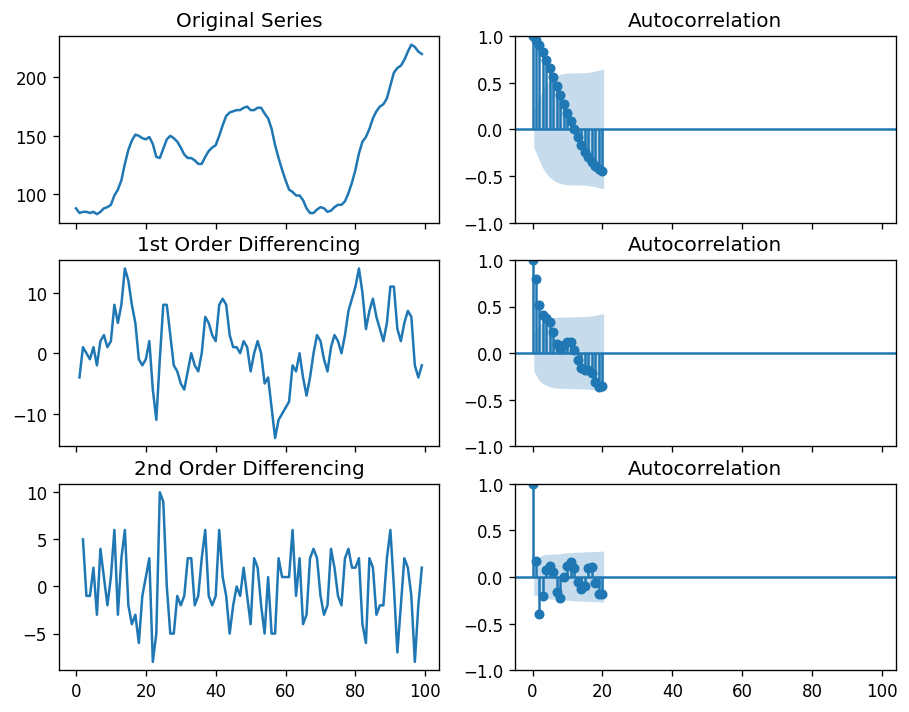

In [1]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

### Determine p

If we think of the AR as linear regression, then the PACF provides likely coeffcients for each of the lagged terms in the AR sum (a_k). Thus p is the number of significant PACF coeffcients. PACF is chosen as it removes effects of prior values in the time series, by using the conditional density i.e. removes residual term   

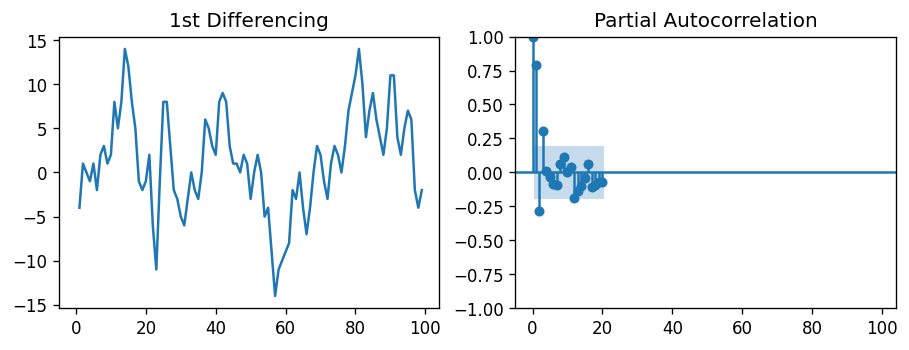

In [17]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1], method = 'ywm')

plt.show()

### Select q

We look at the ACF and use the lagged terms to decide how many terms are required to remove the significant autocorrelation

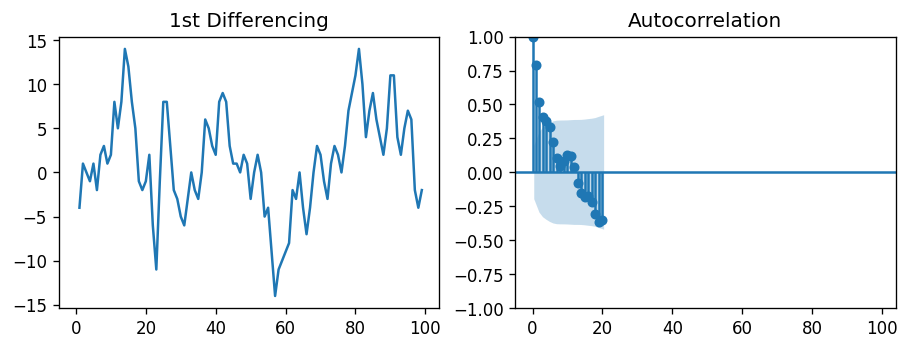

In [3]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

## ARIMA Model

make an ARIMA(1,1,2) model

In [4]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Mon, 11 Apr 2022   AIC                            516.253
Time:                        12:03:55   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

For a quick evaluation of the model we want the AIC, BIC and HQIC to be low. The contributions of the coeffcients is measured by P>|z|, we want this value to be under the signficance level (0.05 in this case) for the contribution to be meaningful. Only MA_L2 is not significant so we remove it by making an ARIMA(1,1,1) 

In [5]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -254.150
Date:                Mon, 11 Apr 2022   AIC                            514.300
Time:                        12:03:55   BIC                            522.086
Sample:                             0   HQIC                           517.450
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6504      0.090      7.258      0.000       0.475       0.826
ma.L1          0.5256      0.088      5.994      0.000       0.354       0.697
sigma2         9.7934      1.405      6.970      0.0

Which is an improvement of the previous model. 

Next we look at the residual. We want a constant mean (ideally 0) and uniform varaince so that it is like white noise 

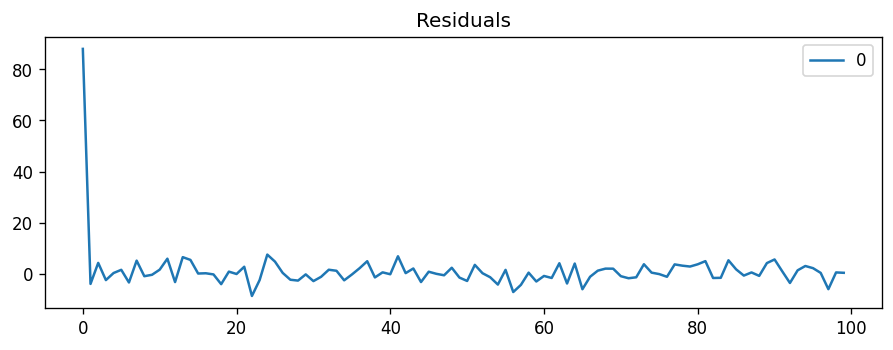

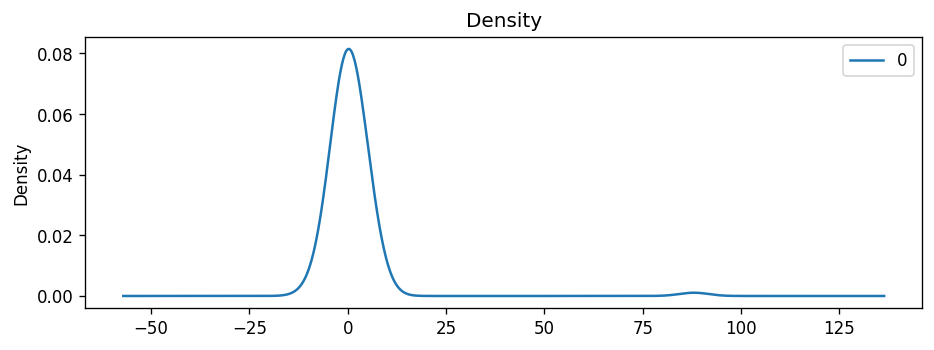

In [6]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
#fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals")
residuals.plot(kind='kde', title='Density')
plt.show()

This appears good, so we plot the fitted values against the actual values

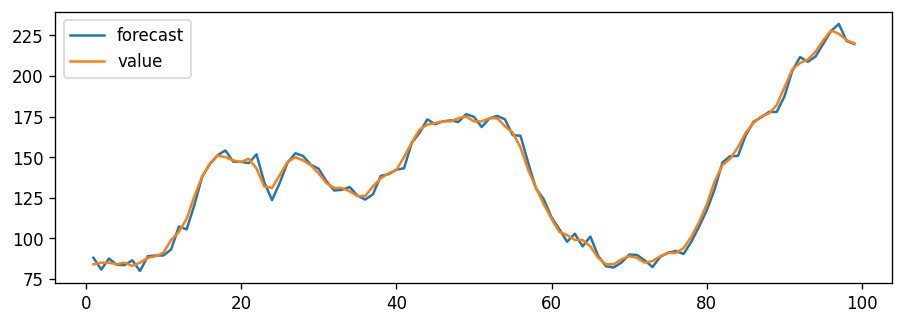

In [18]:
# Actual vs Fitted

df_length = df.shape[0] 
#model_fit.plot_predict(dynamic=False)
res = model_fit.predict(0,df_length-1,dynamic=False)
#print(res)
plt.plot(res[1:df_length],label="forecast")
plt.plot(df.value[1:df_length],label="value")
plt.legend()

Although the above graph looks good the dynamic = False parameter, causes the previous actual values to train the model just before a prediction is done. This makes the graph artifically good.

## ARIMA Model Forecasting Comparison

First split data into training(85%) and test(15%) data sets

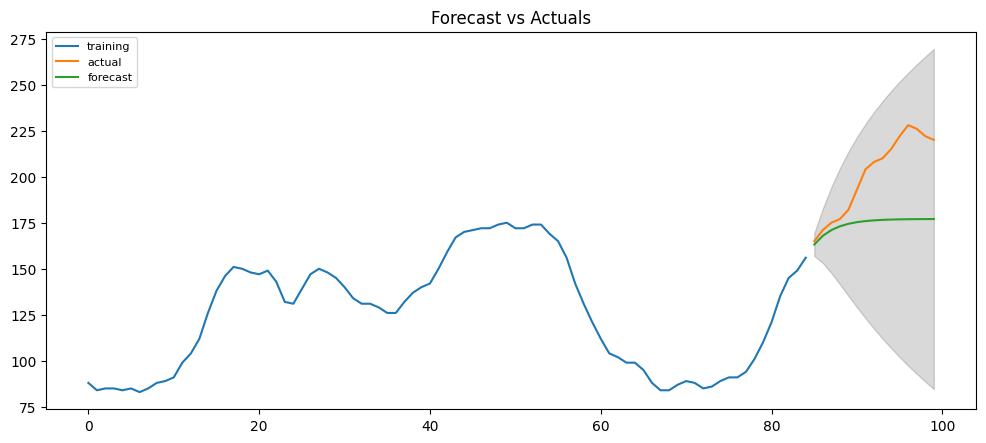

In [19]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  

# Forecast
forecast = fitted.get_forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(forecast.predicted_mean, index=test.index)
conf = forecast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:,0], index=test.index)
upper_series = pd.Series(conf.iloc[:,1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As can be seen the model is within the 95% confidence interval, however it is clear that the addition of a constant would significantly improve the prediction. We cycle through different parameters for (p,d,q) and arrive at ARIMA(3,2,1) being the best with the reults below

c:\users\julba\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   85
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -214.430
Date:                Mon, 11 Apr 2022   AIC                            438.860
Time:                        12:07:57   BIC                            450.954
Sample:                             0   HQIC                           443.719
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1364      0.132      8.606      0.000       0.878       1.395
ar.L2         -0.5883      0.151     -3.897      0.000      -0.884      -0.292
ar.L3          0.3023      0.128      2.359      0.0

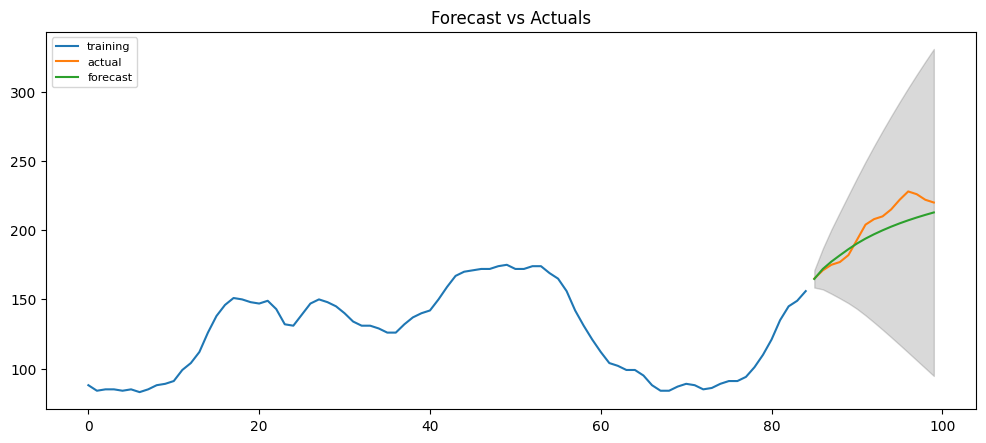

In [20]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
forecast = fitted.get_forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
#fc_series = pd.Series(fitted.forecast(15), index=test.index)
fc = forecast.predicted_mean
fc_series = pd.Series(fc, index=test.index)
conf = forecast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:,0], index=test.index)
upper_series = pd.Series(conf.iloc[:,1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Visually the improvement can be easily seen and the AIC going from 514 to 438 confirms this. Next we define proper test metrics.

### Test Metrics
A breif overview of common test metrics

###### Mean Absolute Percentage Error (MAPE)
Gives error as percentage (0,1), this allows it to be compared with other time series models. Best performance when there is no extremes in the data and is undefined for actual data equal to zero.

###### Mean Error (ME)
Don't use as positive errors cancel out negative errors. 

###### Mean Absolute Error (MAE)
Gives the size of the average error

###### Mean Percentage Error (MPE)
Because of error signs postives will cancel negatives. This allows for bias in the data set to be seen.

###### Root Mean Squared Error (RMSE)
Is the standard deviation of the residual terms (error). Thus for linear regression it indicates how closely grouped the predicted points are to the line of best fit. For example if the data has correlation 1 then RMSE is 0 as all points lie on the straight line. 

###### Lag 1 Autocorrelation of Error (ACF1)
This should be low, else there is a missed pattern in the residual.


###### Correlation between the Actual and the Forecast (corr)
This should be high (ideally 1) as the two should be highly correlated.

###### Min-Max Error (minmax)
The ratio of the predicted and actual value such that it is always less than 1, are averaged with the result being subtracted from 1. Thus ideally this should be close to 0, unless there is a major difference between the forecasted and actual value.

In [21]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

#> {'mape': 0.02250131357314834,
#>  'me': 3.230783108990054,
#>  'mae': 4.548322194530069,
#>  'mpe': 0.016421001932706705,
#>  'rmse': 6.373238534601827,
#>  'acf1': 0.5105506325288692,
#>  'corr': 0.9674576513924394,
#>  'minmax': 0.02163154777672227}

<ipython-input-21-d7b1a06b0a4b>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
<ipython-input-21-d7b1a06b0a4b>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],


{'mape': 0.04115010286260561,
 'me': -7.120170618337185,
 'mae': 8.776341392470806,
 'mpe': -0.03183614012202766,
 'rmse': 10.684070194856957,
 'acf1': 0.8588876829227783,
 'corr': 0.9734725217608518,
 'minmax': 0.0410515472516958}

A MAPE result of 4.11% implies that the model is 95.89% accurate in forecasting the next 15 observations.

## Automating Model Creation

In [22]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

c:\users\julba\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\julba\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   85
Model:                 ARIMA(4, 2, 2)   Log Likelihood                -214.357
Date:                Mon, 11 Apr 2022   AIC                            442.715
Time:                        12:08:55   BIC                            459.647
Sample:                             0   HQIC                           449.517
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1652      0.236      0.699      0.485      -0.298       0.628
ar.L2          0.5191      0.232      2.242      0.025       0.065       0.973
ar.L3         -0.2823      0.143     -1.971      0.0

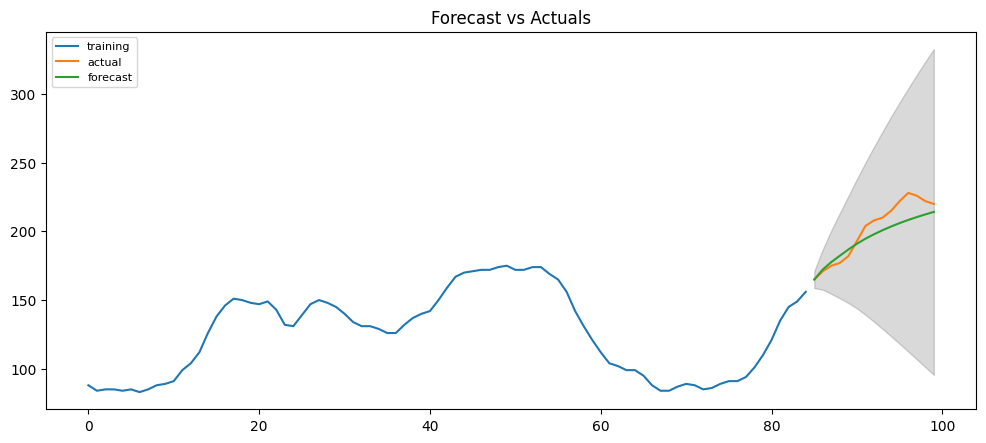

In [23]:
# Build Model
model = ARIMA(train, order=(4, 2, 2))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
forecast = fitted.get_forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
#fc_series = pd.Series(fitted.forecast(15), index=test.index)
fc = forecast.predicted_mean
fc_series = pd.Series(fc, index=test.index)
conf = forecast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:,0], index=test.index)
upper_series = pd.Series(conf.iloc[:,1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Season

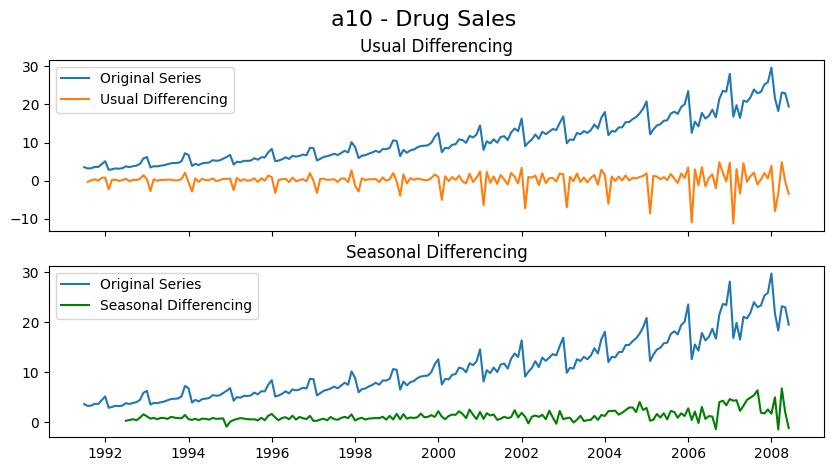

In [34]:
# Import
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

As can be seen by taking the seasonal difference the residual has no pattern, whereas the residual of a single difference clearly retains the pattern.

In [ ]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=2.58 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.20 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.09 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=6.26 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=2.57 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.521, Time=7.32 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.73 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=2.78 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.40 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=4.02 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI